In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = '*'
os.environ['KAGGLE_KEY'] = '*'

In [ ]:
!kaggle datasets download -d muhammadkhalid/sign-language-for-numbers

sign-language-for-numbers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip sign-language-for-numbers.zip

Streaming output truncated to the last 5000 lines.
  inflating: Sign Language for Numbers/7/seven_549.jpg  
  inflating: Sign Language for Numbers/7/seven_55.jpg  
  inflating: Sign Language for Numbers/7/seven_550.jpg  
  inflating: Sign Language for Numbers/7/seven_551.jpg  
  inflating: Sign Language for Numbers/7/seven_552.jpg  
  inflating: Sign Language for Numbers/7/seven_553.jpg  
  inflating: Sign Language for Numbers/7/seven_554.jpg  
  inflating: Sign Language for Numbers/7/seven_555.jpg  
  inflating: Sign Language for Numbers/7/seven_556.jpg  
  inflating: Sign Language for Numbers/7/seven_557.jpg  
  inflating: Sign Language for Numbers/7/seven_558.jpg  
  inflating: Sign Language for Numbers/7/seven_559.jpg  
  inflating: Sign Language for Numbers/7/seven_56.jpg  
  inflating: Sign Language for Numbers/7/seven_560.jpg  
  inflating: Sign Language for Numbers/7/seven_561.jpg  
  inflating: Sign Language for Numbers/7/seven_562.jpg  
  inflating: Sign Language for Numbers/

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import random

In [ ]:
data_directory = "/content/Sign Language for Numbers"
td = "/content/train"
vd = "/content/validation"
ttd = "/content/test"

os.makedirs(td, exist_ok=True)
os.makedirs(vd, exist_ok=True)
os.makedirs(ttd, exist_ok=True)

for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)
    tsd = os.path.join(td, folder_name)
    vsd = os.path.join(vd, folder_name)
    ttsd = os.path.join(ttd, folder_name)
    os.makedirs(tsd, exist_ok=True)
    os.makedirs(vsd, exist_ok=True)
    os.makedirs(ttsd, exist_ok=True)
    file_list = os.listdir(folder_path)
    random.shuffle(file_list)
    num_files = len(file_list)
    num_train = int(0.7 * num_files)
    num_val = int(0.1 * num_files)
    num_test = int(0.2 * num_files)
    train_files = file_list[:num_train]
    val_files = file_list[num_train:num_train+num_val]
    test_files = file_list[num_train+num_val:num_train+num_val+num_test]
    for file_name in train_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(tsd, file_name)
        shutil.move(src_path, dst_path) 
    for file_name in val_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(vsd, file_name)
        shutil.move(src_path, dst_path)
    for file_name in test_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(ttsd, file_name)
        shutil.move(src_path, dst_path)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64
PATH = 'model.pth'

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [ ]:
train_dataset = ImageFolder('/content/train', transform=transforms)
validation_dataset = ImageFolder('/content/validation', transform=transforms)
test_dataset = ImageFolder('/content/test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import torchvision as torchvision
model = torchvision.models.shufflenet_v2_x1_0(pretrained=False).to(device)
model.fc = nn.Linear(model.fc.in_features, 11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_loader)
    epoch_training_accuracy = running_training_accuracy / len(train_loader.dataset)
    training_loss.append(epoch_training_loss)
    training_accuracy.append(epoch_training_accuracy)
    
    running_validation_loss = 0.0
    running_validation_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)  
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_validation_accuracy += torch.sum(preds == labels.data)
    
    epoch_validation_loss = running_validation_loss / len(validation_loader)
    epoch_validation_accuracy = running_validation_accuracy / len(validation_loader.dataset)
    validation_loss.append(epoch_validation_loss)
    validation_accuracy.append(epoch_validation_accuracy)
    
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy, epoch_validation_loss, epoch_validation_accuracy))
    torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [50/235], Loss: 2.1973700523376465
Epoch [1/10], Step [100/235], Loss: 1.7147196531295776
Epoch [1/10], Step [150/235], Loss: 1.7953218221664429
Epoch [1/10], Step [200/235], Loss: 1.4154350757598877
Epoch [1/10], Training Loss: 1.7930735712355756, Training Accuracy: 0.3751746118068695, Validation Loss: 1.8041464966535568, Validation Accuracy: 0.3831954002380371
Epoch [2/10], Step [50/235], Loss: 1.1807562112808228
Epoch [2/10], Step [100/235], Loss: 1.2650893926620483
Epoch [2/10], Step [150/235], Loss: 0.6920181512832642
Epoch [2/10], Step [200/235], Loss: 0.6864680051803589
Epoch [2/10], Training Loss: 0.8945334349540954, Training Accuracy: 0.6983968019485474, Validation Loss: 1.645597175359726, Validation Accuracy: 0.47517502307891846
Epoch [3/10], Step [50/235], Loss: 0.5149681568145752
Epoch [3/10], Step [100/235], Loss: 0.5146754384040833
Epoch [3/10], Step [150/235], Loss: 0.6207138299942017
Epoch [3/10], Step [200/235], Loss: 0.44596895575523376
Epoch [3/10]

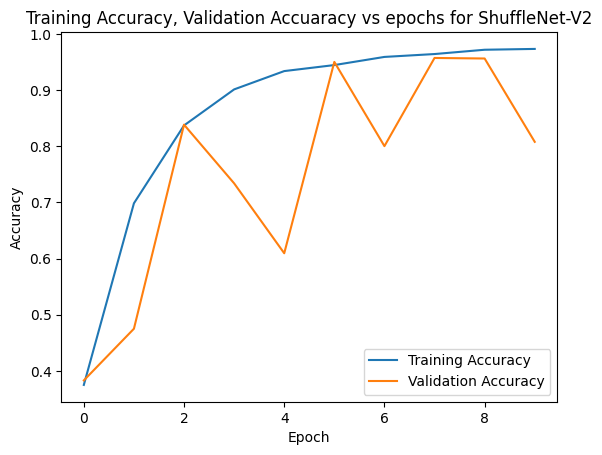

In [ ]:
training_accuracy_tensor = torch.tensor(training_accuracy)
validation_accuracy_tensor = torch.tensor(validation_accuracy)

plt.plot(training_accuracy_tensor.to('cpu'), label='Training Accuracy')
plt.plot(validation_accuracy_tensor.to('cpu'), label='Validation Accuracy')
plt.title('Training Accuracy, Validation Accuaracy vs epochs for ShuffleNet-V2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test Accuracy: 0.8083852500420946


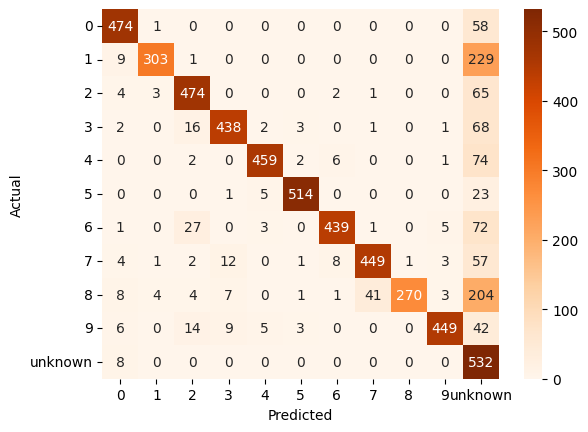

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       533
           1       0.97      0.56      0.71       542
           2       0.88      0.86      0.87       549
           3       0.94      0.82      0.88       531
           4       0.97      0.84      0.90       544
           5       0.98      0.95      0.96       543
           6       0.96      0.80      0.87       548
           7       0.91      0.83      0.87       538
           8       1.00      0.50      0.66       543
           9       0.97      0.85      0.91       528
     unknown       0.37      0.99      0.54       540

    accuracy                           0.81      5939
   macro avg       0.90      0.81      0.83      5939
weighted avg       0.90      0.81      0.83      5939



In [ ]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.tolist())
        test_labels.extend(labels.tolist())

test_acc = accuracy_score(test_labels, test_preds)
print('Test Accuracy: {}'.format(test_acc))

target_names = list(train_dataset.class_to_idx.keys())
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds, target_names=target_names))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15033 samples in 0.265s...
[t-SNE] Computed neighbors for 15033 samples in 597.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15033
[t-SNE] Computed conditional probabilities for sample 2000 / 15033
[t-SNE] Computed conditional probabilities for sample 3000 / 15033
[t-SNE] Computed conditional probabilities for sample 4000 / 15033
[t-SNE] Computed conditional probabilities for sample 5000 / 15033
[t-SNE] Computed conditional probabilities for sample 6000 / 15033
[t-SNE] Computed conditional probabilities for sample 7000 / 15033
[t-SNE] Computed conditional probabilities for sample 8000 / 15033
[t-SNE] Computed conditional probabilities for sample 9000 / 15033
[t-SNE] Computed conditional probabilities for sample 10000 / 15033
[t-SNE] Computed conditional probabilities for sample 11000 / 15033
[t-SNE] Computed conditional probabilities for sample 12000 / 15033
[t-SNE] Computed conditional probabilities for s

<ipython-input-17-2abfded69321>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(target_names)-1)
<ipython-input-17-2abfded69321>:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))


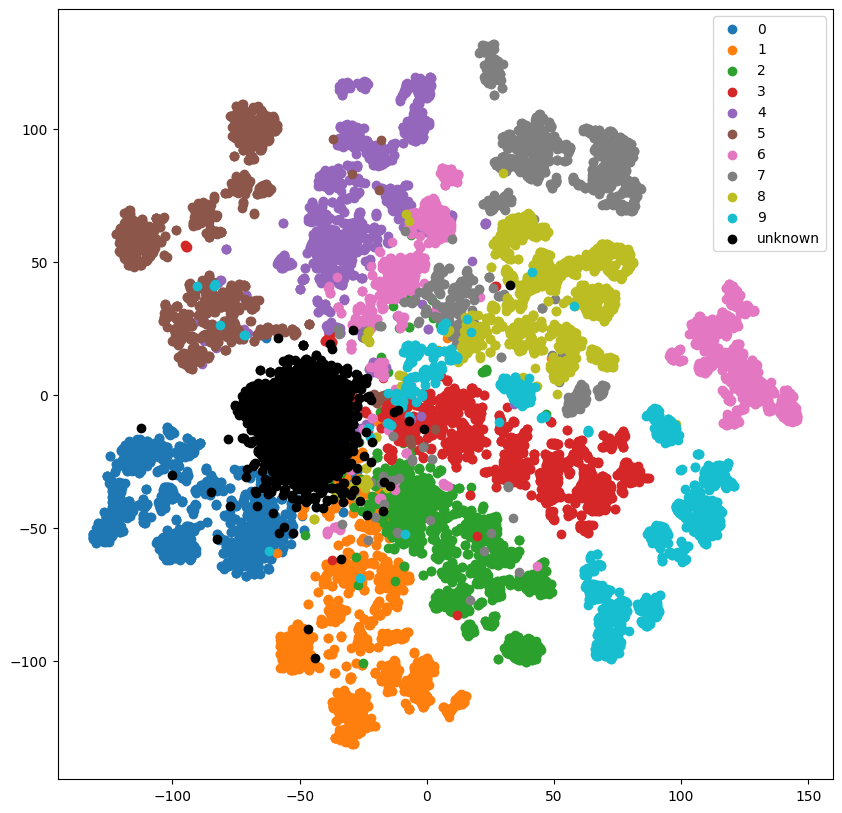

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


model.to('cuda')
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

features = []
labels = []
for images, target in train_loader:
    images = images.to('cuda')
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Reshape features to have only 2 dimensions
features = features.reshape(features.shape[0], -1)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(train_dataset.class_to_idx.keys())

cmap = plt.cm.get_cmap('tab10', len(target_names)-1)


u = labels == target_names.index("unknown")

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    if target_name != "unknown":
        indices = labels == i
        plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c="k")
plt.legend()
plt.show()


